# Decision Trees

Decision Trees are a [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) [supervised machine learning](https://en.wikipedia.org/wiki/Supervised_learning) algorithm that takes a set of training data and constructs a set of regions in the space of features that is then used to make predictions. These predictions can be continuous values (Decision Tree Regression), or classification (Decision Tree Classification).

[caption id="attachment_2353" align="aligncenter" width="1000"]<img class="wp-image-2353 size-full" src="https://bryantravissmithdotcom.files.wordpress.com/2016/11/decision-tree-algorithm-page-1.png" alt="Decision Tree Process" width="1000" height="580" /> High Level Decision Tree Process[/caption]

 

Let's imagine we have a data set with a lot of features and how much student debt individuals have. We could just take the average of the entire dataset, say $25,000.00, and use that as a prediction. A better prediction could be developed by dividing the dataset up using the level of college completed: None, Some, Undergraduate, and Graduate. We can then take the average of subset/region:

1. None: \$0
2. Some: \$2000
3. Undergraduate: \$16000
4. Graduate: \$42000

Now when we score a person, we use their level of college completed to make the prediction. The idea is that the results are improved over the $25,000 average estimate of the entire dataset.

<img class="aligncenter size-full wp-image-2356" src="https://bryantravissmithdotcom.files.wordpress.com/2016/11/decision-tree-algorithm-page-2.png" alt="Student Loan Example" width="768" height="529" />

 


## Why Implement It Ourselves?

The reason why I want to implement machine learning algorithm from scratch is I have a better intuition for the assumptions and the trade off in the implementations of standard libraries. For instance, before I did this for the first time I did not appreciate that both [sklearn](http://scikit-learn.org/stable/) (python) and [rpart](https://cran.r-project.org/web/packages/rpart/index.html) (R) have an implementation of the [CART](https://en.wikipedia.org/wiki/Decision_tree_learning?#Types) algorithm for decision trees, but there are equally valid decision tree algorithms that would produce different results. This implementation is inherently [greedy](https://en.wikipedia.org/wiki/Greedy_algorithm). The issue with greedy algorithms is that making locally best splits or regions may not make the globally best set of regions. This is what makes finding the best Decision Tree model [np-hard](https://en.wikipedia.org/wiki/NP-hardness). If you really get into it, finding the best tree becomes an [optimal stopping](https://en.wikipedia.org/wiki/Optimal_stopping) problem and brushes into [Reinforcement Learning](https://en.wikipedia.org/wiki/Reinforcement_learning) and [Artifical Intelligence](https://en.wikipedia.org/wiki/Artificial_intelligence) style searching.

On a more practical side, there have been a number of times in the iterative approach of model-building where understanding the model assumptions have allowed me to exclude features the violate assumptions, or create new features that are more easily expressed and represented by the model. Both of these have consistently lead to better out of sample performance.

Finally, the best reason is I get pleasure and satisfaction from doing this. I think algorithms are a powerful framework and a fun way to think about problems solving and doing things from scratch help improve about execution and understanding of them.

## Metrics - Measures for Improvement

I made up the student debt example. It makes sense in my mind, but we need to define an algorithm that can create the regions from any dataset. Most machine learning algorithms are optimization algorithms that improve some measure/metric on each iteration. Decision trees are no different in that respect. To define the algorithm, we need to define the measures.

### Classification Metrics for Decision Trees

#### Gini Impurity

Gini Impurity is a very intuitive metric to try to improve because it is a measure of the misclassification rate. If the fraction of the data set that has outcome class $  c  $ is $  f_c  $, we can make predictions for each data point as being class $  c  $, $  f_c  $ of the time. The error rate for a class is the probability of getting the class times the probability of getting it wrong.

$$  Error_c = f_c * \left( 1 - f_c \right)  $$

The Gini Impurity is the sum of these error rates for all classes.

$$  Gini \ Impurity = \sum_c Error_c = \sum_c f_c * \left( 1 - f_c \right)  $$
$$  Gini \ Impurity = \sum_c f_c - \sum _c f^2_c  $$
$$  Gini \ Impurity = 1 - \sum _c f^2_c  $$

If we divide the data set in regions that improve the weighted sum of the Gini Impurity, the misclassification rate will be reduced.

#### Gini Impurity for a Coin Flip

A coin flip is about as simple as a process there is to calculate the Gini Impurity for. We have a coin with probability of head, $  p_H  $. The Gini Impurity is then
$$  Gini \ Impurity = 1 - p_H^2 - \left(1-p_H\right)^2 = 2*p_H*\left(1-p_H\right)  $$
A plot of the this is below for different values of $  p_H  $.

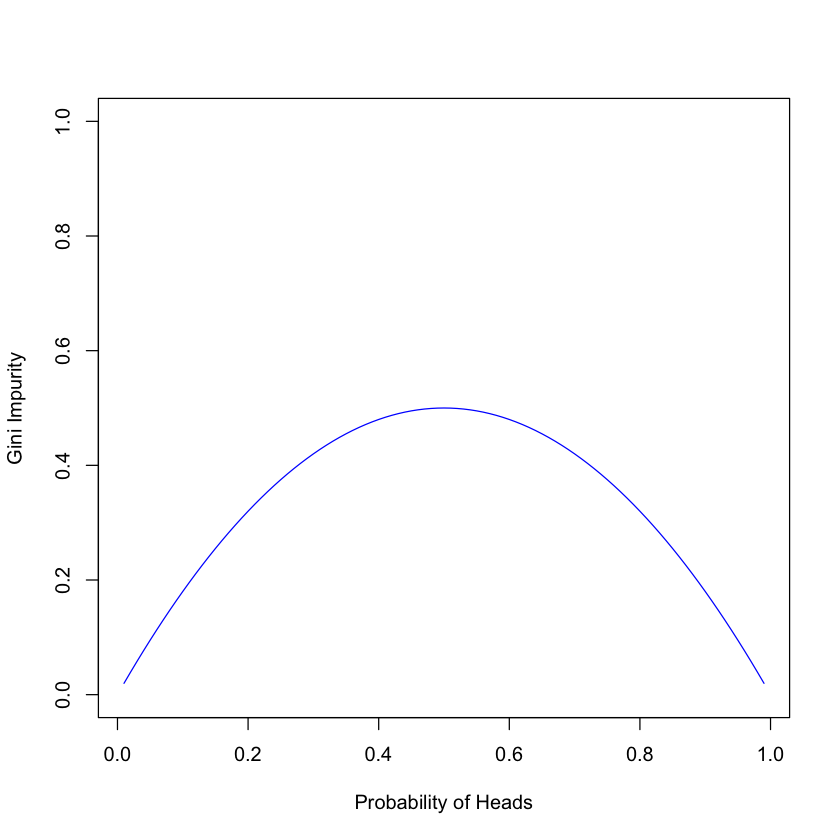

In [1]:
p <- seq(0.01,0.99,0.01)
plot(p,
     1-p^2-(1-p)^2,
     type='l',
     ylim=c(0,1),
     ylab = "Gini Impurity",
     xlab="Probability of Heads",
     col="blue")

We see that if $  p_H = 0  $ or $  p_H = 1  $ there is no misclassification. If $  p_H = 0.5  $, we see that we get the coin flip wrong 50% of the time. This should match our intuition.

#### Entropy

Another, and less intuitive, measure of prediction accuracy is entropy. It is defined as the expected information content of a class. If $f_c$ is the fraction of the class in a dataset, and $  I(c)  $ is the information content in the class, then entropy is defined as following
$$  Entropy = \sum_c f_c * I(c)  $$
For reasons I will not get into in this post, $  I(c) = - log_2\left(f_c\right)  $, so the entropy of a dataset follows:
$$  Entropy = - \sum_c f_c * log_2\left(f_c\right)  $$
The base 2 of the log can be anything, really. But since we will be using binary trees throughout this series, I will keep the base 2.

#### Entropy for a Coin Flip

Continuing with the coinflip example, I have produced the entropy of a coinflip using different values of $  p_H  $.

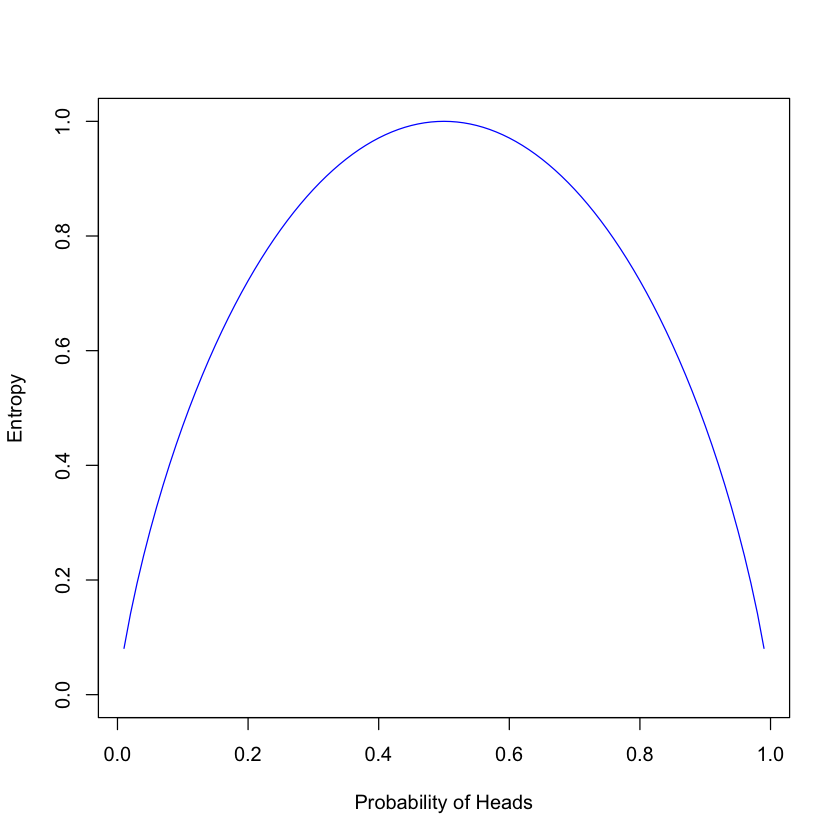

In [2]:
p <- seq(0.01,0.99,0.01)
plot(p,
     -p*log2(p)-(1-p)*log2(1-p),
     type='l',
     ylim=c(0,1),
     ylab = "Entropy",
     xlab="Probability of Heads",
     col="blue")

<img class="aligncenter size-full wp-image-2381" src="https://bryantravissmithdotcom.files.wordpress.com/2016/11/screen-shot-2016-11-26-at-2-05-48-pm.png" alt="screen-shot-2016-11-26-at-2-05-48-pm" width="768" height="402" />

The expected information content of $  p_H = 0  $ and $  p_H = 1  $ is zero, which means that we always know what the next flip is. The entropy is maximum for $  p_H = 0.5  $, which is where we have the highest misclassification rate

### Regressions Metrics for Decision Trees

The metric used for decision tree regression is a reduction of  variance around the prediction.

$$  Variance = \frac{1}{N} \sum_{i}^{N} ( y_i - \bar{y} )^2  $$

#### Simple Linear Example

We can take a simple linear example and split it into two regions. The solid black line is the average of the entire dataset, while the red lines are the predictions in each region.

<img class="aligncenter size-full wp-image-2747" src="https://bryantravissmithdotcom.files.wordpress.com/2016/12/output_11_0.png" alt="output_11_0" width="768" height="384" />

The total variance before the split was 40.00, while the weighted variance after the split is $  \frac{6}{11} 11.67 + \frac{5}{11} 8.00  $ = 10.0

## Improving Metrics - Splitting on Information Gain

Now that we have metrics to evaluate the prediction from a data set, we can now define the improvement metric to optimize. I will be using the term information gain, which it is the correct term when talking about entropy, for all the optimizations. I can not say conclusively is the name for the measure in decision tree regression. Being wrong hasn't stopped me before!

### Decision Tree Classifier 

$$  Information \ Gain = Gini \ Impurity(d) - \sum_{split \ s} \frac{|s|}{|d|} Gini \ Impurity(s)  $$

$$  Information \ Gain = Entropy(d) - \sum_{split \ s} \frac{|s|}{|d|} Entropy(s)  $$

### Decision Tree Regressor
 

$$  Information \ Gain =  Variance(d) - \sum_{split \ s} \frac{|s|}{|d|} Variance(s)  $$

## Parameters of Decision Trees

Decisions Trees are prone to overfit because the metrics can be driven to the minimum by making the tree deep enough capture each data point individually. The variance of a single point is zero. The misclassification rate of a single point is also zero. Traditionally this overfit is managed by pruning the tree after it is constructed, or setting parameters the limit how finely the data can be partitioned into regions.

The post-pruning of a decision tree uses some sort of statistical evaluation on a validation set. If the error on the sub-nodes is larger than the node, the sub-nodes are removed.

The parameters that are commonly used in CART to limit the partitioning of the data:

1. Maximum Depth of the Tree
2. Minimum Number of Data Points for a New Node
3. Minimum Improvement needed for a New Node
4. Minimum Metric under which New Nodes are not created.

## Pseudo Code
Now that we have a metric and measure of improvement, we can outline the pseudo code we will be implementing in the next posts which are based on the CART algorithm for decision trees. Classification and Regression Trees (CART) algorithm that recursively and greedily splits nodes if there is an improve in the metric of choice until some stopping conditions are met.

<ol>
	<li>Set Training Parameters</li>
	<li>Create a Root Node</li>
	<li>Determine optimal split the node such that that split minimizes the metrics of concern.</li>
	<li>If stopping parameters are not violated, create two child nodes and apply step 3 and 4 to each child node.</li>
</ol>

# Code

In this code section. I am going to be implementing a Decision Tree algorithm, but I will do it in the following parts:

<ol>
	<li>Introduce the Data</li>
	<li>Script Finding the Best First Partition</li>
	<li>Create a Data Structure and Implement Decision Trees</li>
	<li>Comparing with rpart package.</li>
</ol>

## Assumptions
The implementation will avoid some issues with decision trees. I am going to assume that there never missing values. I will assume that all categorical variables are logical, character, and factor variables. If a variable is numeric, I will assume it is numeric. I am also going to assume that all the data is in a data.frame format.

## Data

I will be using the Iris dataset for classification and the ToothGrowth dataset for regression. Both are available in the R datasets package

In [3]:
library(datasets)
data(iris)
data(ToothGrowth)

#### Iris

I will be using the Species as the classification target in this post. Here are the top 6 rows of the dataset:

In [4]:
head(iris)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species
1 5.1          3.5         1.4          0.2         setosa 
2 4.9          3.0         1.4          0.2         setosa 
3 4.7          3.2         1.3          0.2         setosa 
4 4.6          3.1         1.5          0.2         setosa 
5 5.0          3.6         1.4          0.2         setosa 
6 5.4          3.9         1.7          0.4         setosa

#### ToothGrowth

I will be using the 'len' variable as the regression target in this post. Here are the top 6 rows of the ToothGrowth dataset:

In [5]:
head(ToothGrowth)

len  supp dose
1  4.2 VC   0.5 
2 11.5 VC   0.5 
3  7.3 VC   0.5 
4  5.8 VC   0.5 
5  6.4 VC   0.5 
6 10.0 VC   0.5

## Scripting the First Partition

I am going to implement a brute force search for the best partition in the data set. This will be done by going through each value in each feature and finding the feature-value that will best partition the data. To do this we need to implement our metrics I discussed in the theory post:

Entropy: Classification
Gini Impurity: Classification
Variance: Regression

In [6]:
entropy <- function(y){
  # assumes y is a factor with all levels
  if(length(y)==0) return(0)
  p <- table(y)/length(y)
  sum(-p*log2(p+1e-9))
}

gini_impurity <- function(y){
  # assumes y if a factor with all levels
  if(length(y) == 0) return(0)
  p <- table(y)/length(y)
  1-sum(p^2)
}

variance <- function(y){
  if(length(y) <= 1) return(0)
  var(y)
}

I can quickly calculate these metrics for our dataset:

In [7]:
entropy(iris[,'Species'])
gini_impurity(iris[,'Species'])
variance(ToothGrowth[,'len'])

[1] 1.584962

[1] 0.6666667

[1] 58.51202

## Information Gain

Now that I have metric functions, I want to calculate the improvement for different partitions. Each partition is going to be calculated using a mask which is a logical vector that states if the row is in the first partition (TRUE) or in the second partition (FALSE). I will call the function information gain, even though it really is only information gain if entropy is the metric.

In [8]:
information_gain <- function(y,mask,func=entropy){
    s1 = sum(mask)
    s2 = length(mask)-s1
    if ( s1 == 0 | s2 == 0) return(0)
    func(y)-s1/(s1+s2)*func(y[mask])-s2/(s1+s2)*func(y[!mask])
}

information_gain(iris[,'Species'],iris[,'Petal.Width'] < 1.5)
information_gain(iris[,'Species'],iris[,'Petal.Width'] < 1.5,gini_impurity)
information_gain(ToothGrowth[,'len'],ToothGrowth[,'dose']<= 0.5,variance)

[1] 0.6435164

[1] 0.2290455

[1] 33.87901

## Max Information Gain For A Single Feature

I have a function to calculated the information gain for a given criteria, mask, or split, I now will search for the best split among all the values in a given feature. This will give me the best split for that feature:

In [9]:
max_information_gain_split <- function(y,x,func=gini_impurity){
  best_change = NA
  split_value = NA
  is_numeric = !(is.factor(x)|is.logical(x)|is.character(x))
  for( val in sort(unique(x))){
    mask <- x == val
    if (is_numeric) mask <- x < val
    change <- information_gain(y,mask,func) 
    if(is.na(best_change) | change > best_change){
      best_change = change
      split_value = val
    }
  }
  return(list("best_change"=best_change,
      "split_value"=split_value,
      "is_numeric"=is_numeric))
}

print(unlist(max_information_gain_split(iris$Species,iris$Petal.Width)))
print(unlist(max_information_gain_split(iris$Species,iris$Petal.Width,entropy)))
print(unlist(max_information_gain_split(ToothGrowth$len,ToothGrowth$dose,variance)))

best_change split_value  is_numeric 
  0.3333333   1.0000000   1.0000000 
best_change split_value  is_numeric 
  0.9182958   1.0000000   1.0000000 
best_change split_value  is_numeric 
   33.87901     1.00000     1.00000 


All the best split values just happen to be 1 in this case.

## Max Information Again Among All Features

Now I can apply 'max_information_gain_split' to all of the feature columns and find the best split. We will do this by applying a 'sapply ' function on the features like so:

In [10]:
sapply(iris[,1:4],function(x) max_information_gain_split(iris[,5],x))

Sepal.Length Sepal.Width Petal.Length Petal.Width
best_change 0.2277603    0.1269234   0.3333333    0.3333333  
split_value 5.5          3.4         3            1          
is_numeric  TRUE         TRUE        TRUE         TRUE

In [11]:
sapply(ToothGrowth[,2:3],function(x) max_information_gain_split(ToothGrowth[,1],x))

supp       dose      
best_change 0.01444444 0.02027778
split_value OJ         2         
is_numeric  FALSE      TRUE

After 'sapplying' the function, I will return a list with the information of the feature and value with the most information gain.

In [12]:
best_feature_split <- function(X,y){
  results <- sapply(X,function(x) max_information_gain_split(y,x))
 best_name <- names(which.max(results['best_change',]))
 best_result <- results[,best_name]
 best_result[["name"]] <- best_name
 best_result
}

as.data.frame(best_feature_split(iris[,1:4],iris[,5]))
as.data.frame(best_feature_split(ToothGrowth[,2:3],ToothGrowth[,1]))

best_change split_value is_numeric name        
1 0.3333333   3           TRUE       Petal.Length

best_change split_value is_numeric name
1 0.02027778  2           TRUE       dose

Now that I have the best feature-value combination to partition our data we can partition the data into the two data sets. One I will call 'left', and the other I will call 'right'. This will end up being the data structure use in that each node can have two branches: left and right.

In [13]:
get_best_mask <- function(X,best_feature_list){
  best_mask <- X[,best_feature_list$name] == best_feature_list$split_value
  if(best_feature_list$is_numeric){
    best_mask <- X[,best_feature_list$name] < best_feature_list$split_value
  }
  return(best_mask)
}


best_first_split <- best_feature_split(ToothGrowth[,2:3],ToothGrowth[,1])
best_tooth_mask <- get_best_mask(ToothGrowth[,2:3],best_first_split)
leftDf = ToothGrowth[best_tooth_mask,]
rightDf = ToothGrowth[!best_tooth_mask,]

Now that I have scripted a single split, I will now work on creating a tree-based data structure for the decision tree.

## Data Structure

R is a functional language, but I decided to take a more object oriented approach to implementing my decision tree. If you want to examine a function approach, you can examine the code in the rpart package.

I decided this route partially because it is how I think of the problem, but that does not make it the best implementation. A truer reason is that I also wanted to take this post as an opportunity to play around with R's Reference Classes object implementation. Hadley Wickham has a good [Reference Classes overview](http://adv-r.had.co.nz/R5.html). I have never used these before this post. Be warned.

I am going to make two classes. Decision Tree class that slightly mimics the sklearn API and a Decision Tree Node class will recursively fit the data based on the hyper-parameters we provide. There are many parameters that one could set to control the tree from overfitting. I have have choose: max_depth, min_information_gain, & min_leaf_size. Class diagrams are below.

[caption id="attachment_2649" align="aligncenter" width="768"]<img class="size-full wp-image-2649" src="https://bryantravissmithdotcom.files.wordpress.com/2016/12/decision-tree-algorithm-page-31.png" alt="Class Descriptions of Decision Tree Implementation" width="768" height="448" /> Class Descriptions of Decision Tree Implementation[/caption]

 

# DecisionTreeNode

This is going to be the template I will use for the DecisionTreeNode class.  It is using R's Reference Class objects.

In [14]:
DecisionTreeNode <- setRefClass("DecisionTreeNode",
    fields = list(
        x = "data.frame",
        y = "ANY",
        is_leaf="logical",
        split_description="character",
        best_split="list",
        branches="list",
        depth="numeric",
        minimize_func="function",
        min_information_gain="numeric",
        min_leaf_size="numeric",
        max_depth="numeric"),
    methods = list(
        initialize = function(...){},
        information_gain = function(mask){},
        max_information_gain_split = function(feature){},
        best_feature_split = function(){},
        split_node = function() {},
        predict_row = function(row){},
        predict = function(features){}
     )
)

### Print

I want to set the print on a DecisionTreeNode to give a summary of the entire structure and decisions. To do this I am recursively descending down the tree to get the node description, then append it the response. After all the responses have been returned to the root level, I cat the response so that I can take advantage of the tab/'\t' and newline/'\n' syntax.

In [15]:
print.DecisionTreeNode <- function(node,level=0){
    response <- paste("|->",node$split_description)
    if(level < node$max_depth){
         if(!is.null(node$branches$left)){
           response <- paste0(response,"\n",paste(rep(" ",2*(level+1)),collapse=" "),print(node$branches$left,level+1))
        }
        if(!is.null(node$branches$right)){
            response <- paste0(response,"\n",paste(rep(" ",2*(level+1)),collapse=" "),print(node$branches$right,level+1))
        }
    }

    if(level==0) {
        cat(response)
    } else {
        return(response)
    }
}

### Initialize Function

This function gets called when a *DecisionTreeNode\$new()* gets called. In it, I set a list of default values. I iterate through the parameters provided to the $new(...) function and if a default parameter is not set, I set it with the *do.call* command.

### Initialize Function

This function gets called when a *DecisionTreeNode\$new()* gets called. In it, I set a list of default values. I iterate through the parameters provided to the $new(...) function and if a default parameter is not set, I set it with the *do.call* command.

```R
initialize = function(...){
   defaults <- list(x = data.frame(),
                    y=c(),
                    depth=0,
                    minimize_func=gini_impurity,
                    min_information_gain=1e-2,
                    min_leaf_size=20,
                    max_depth=3,
                    is_leaf=T,
                    split_description="root",
                    best_split=NULL,
                    branches=list("left"=NULL,"right"=NULL))

   params <- list(...)
   fields <- names(getRefClass()$fields())
   for( field in fields){
       if (!(field %in% names(params))) {
           params[[field]] <- defaults[[field]]
       }
   }
   for( param in names(params)){
       do.call("<<-",list(param, params[[param]]))
   }
}
```

### Information Gain

This is the same function as I implemented during the scripting section except that it makes reference to the object variables instead of accepting them as parameters.

```R
information_gain = function(mask){
   s1 = sum(mask)
   s2 = length(mask)-s1
   if ( s1 == 0 | s2 == 0) return(0)
   minimize_func(y)-s1/(s1+s2)*minimize_func(y[mask])-s2/(s1+s2)*minimize_func(y[!mask])
}
```

### Max Information Gain Split

This function finds the value with the most information gain by a given feature. This is similar to the scripted version above except it also makes reference the object's variables and have added an additional constraint that the best split is only updated if it new leafs are bigger or equal to the min leaf size.   This is finding the optimal split value given the constraint.  The above scrippted solution finds the optimal value then checks to see if it matches the constraint.  These two methods will give different results and produce different trees.   

```R
max_information_gain_split = function(feature){

   best_change = NA
   split_value = NA
   is_numeric = !(is.factor(feature)|is.logical(feature)|is.character(feature))

   previous_val <- NA
   for( val in sort(unique(feature))){

       mask <- feature == val

       if (is_numeric) mask <- feature < val
       change <- information_gain(mask) 

       s1 = sum(mask)
       s2 = length(mask)-s1
       if(is.na(best_change) & s1 >= min_leaf_size & s2 >= min_leaf_size){
           best_change = change
           split_value = ifelse(is.na(previous_val),
                                val,
                                mean(c(val,previous_val)))
       } else if( change > best_change & s1 >= min_leaf_size & s2 >= min_leaf_size ){
           best_change = change
           split_value = ifelse(is_numeric,
                                mean(c(val,previous_val)),
                                val)
        }
       previous_val <- val

   }
   return(list("best_change"=best_change,
               "split_value"=split_value,
               "is_numeric"=is_numeric))
}
```

### Best Feature Split

This function finds the feature-value split that gives the most information gain out of the all the features.  It checks to see if there is a best result solution before setting it.  

```R
best_feature_split = function(){
   results <- sapply(x,function(feature) max_information_gain_split(feature))
   if (!all(is.na(unlist(results['best_change',])))) {
       best_name <- names(which.max(results['best_change',]))
       best_result <- results[,best_name]
       best_result[["name"]] <- best_name
       best_split <<- best_result
   }

}
```

### Best Mask

This function finds the mask for the best feature split. This is used to split the node if it is consistent with the hyper-parameters

```R
best_mask = function(){
   best_mask <- x[,best_split$name] == best_split$split_value
   if(best_split$is_numeric){
       best_mask <- x[,best_split$name] < best_split$split_value
   }
   return(best_mask)
}
```

### Split Node

This function will split the DecisionTreeNode into left and right branches if it is consistent with the hyper-parameters. It is also setting each Node's description so a summary tree can be printed out.

```R
split_node = function() {
   if(depth < max_depth){ 
       best_feature_split() 
       if(!is.null(best_split) & best_split$best_change > min_information_gain ){

           mask = best_mask()
           if(sum(mask) >= min_leaf_size && length(mask)-sum(mask) >= min_leaf_size){
               is_leaf <<- F

               branches$left <<- .self$copy()
               branches$left$is_leaf <<- T
               branches$left$x <<-  branches$left$x[mask,]
               branches$left$y <<-  branches$left$y[mask]

               branches$left$split_description <<- ifelse(best_split$is_numeric,
                                                         paste(c(best_split$name,
                                                                 "<",
                                                                 as.numeric(as.character(best_split$split_value))),
                                                               collapse = " "),
                                                         paste(c(best_split$name,
                                                                 "=",
                                                                 best_split$split_value),
                                                               collapse = " "))

               branches$left$depth <<-  branches$left$depth+1
               branches$left$branches <<- list("left"=NULL,"right"=NULL)
               branches$left$split_node()

               branches$right <<- .self$copy()
               branches$right$is_leaf <<- T
               branches$right$x <<-  branches$right$x[!mask,]
               branches$right$y <<-  branches$right$y[!mask]

               branches$right$split_description <<- ifelse(best_split$is_numeric, 
                                                           paste(c(best_split$name, ">=",
                                                                 best_split$split_value),
                                                               collapse = " "),
                                                         paste(c(best_split$name,
                                                                 "!=",
                                                                 best_split$split_value),
                                                               collapse = " "))

               branches$right$depth <<-  branches$right$depth+1
               branches$right$branches <<- list("left"=NULL,"right"=NULL)
               branches$right$split_node()
           }
       }
   }
   if(is_leaf){
       split_description <<- ifelse(identical(minimize_func,variance),
                                          paste(c(split_description,
                                                  ":",
                                                  "predict - ",
                                                  mean(y)),
                                                collapse=" "),
                                          paste(c(split_description,
                                                  ":",
                                                  "predict - ",
                                                  names(which.max(table(y)))),
                                                collapse=" "))
   }

}
```

### Predict Row

This function is used to make a prediction for a single row. It with be used by the predict function.

```R
predict_row = function(row){
   if(is_leaf){
       predict_value <- ifelse(identical(minimize_func,variance),
                               mean(y),
                               names(which.max(table(y))))
   } else {
       if(best_split$is_numeric){
           left = row[best_split$name] < best_split$split_value
       } else{
           left = row[best_split$name] == best_split$split_value
       }
       if(left){
           predict_value = branches$left$predict_row(row)
       } else {
           predict_value = branches$right$predict_row(row)
       }
   }
   return(predict_value)
}
```

### Predict

This function will predict the values from the fitted tree. If the minimizing function is variance, I assume the problem is a regression problem and return numeric values. If it is not, I assume it is a classification problem and return character values.

```R
predict = function(features){
   pred <- character(length=dim(features)[1])
   if(identical(minimize_func,variance)) pred <- numeric(length=dim(features)[1])
   for(i in 1:dim(features)[1]){
       pred[i] = predict_row(features[i,])
   }
   pred
}
```

## Final DecisionTreeNode Code

In [16]:
DecisionTreeNode <- setRefClass("DecisionTreeNode",
   fields = list(x = "data.frame",
              y = "ANY",
              is_leaf="logical",
              split_description="character",
              best_split="list",
              branches="list",
              depth="numeric",
              minimize_func="function",
              min_information_gain="numeric",
              min_leaf_size="numeric",
              max_depth="numeric"),
   methods = list(
       initialize = function(...){
           defaults <- list(x = data.frame(),
                            y=c(),
                            depth=0,
                            minimize_func=gini_impurity,
                            min_information_gain=1e-3,
                            min_leaf_size=20,
                            max_depth=3,
                            is_leaf=T,
                            split_description="root",
                            best_split=NULL,
                            branches=list("left"=NULL,"right"=NULL))

           params <- list(...)
           fields <- names(getRefClass()$fields())
           for( field in fields){
               if (!(field %in% names(params))) {
                   params[[field]] <- defaults[[field]]
               }
           }
           for( param in names(params)){
               do.call("<<-",list(param, params[[param]]))
           }

       },
       information_gain = function(mask){

           s1 = sum(mask)
           s2 = length(mask)-s1
           if ( s1 == 0 | s2 == 0) return(0)
           minimize_func(y)-s1/(s1+s2)*minimize_func(y[mask])-s2/(s1+s2)*minimize_func(y[!mask])
       },
       max_information_gain_split = function(feature){

           best_change = NA
           split_value = NA
           is_numeric = !(is.factor(feature)|is.logical(feature)|is.character(feature))
        
           previous_val <- NA
           for( val in sort(unique(feature))){
               
               mask <- feature == val
               
               if (is_numeric) mask <- feature < val
               change <- information_gain(mask) 
                
               s1 = sum(mask)
               s2 = length(mask)-s1
               if(is.na(best_change) & s1 >= min_leaf_size & s2 >= min_leaf_size){
                   best_change = change
                   split_value = ifelse(is.na(previous_val),
                                        val,
                                        mean(c(val,previous_val)))
               } else if( change > best_change & s1 >= min_leaf_size & s2 >= min_leaf_size ){
                   best_change = change
                   split_value = ifelse(is_numeric,
                                        mean(c(val,previous_val)),
                                        val)
                }
               previous_val <- val

           }
           return(list("best_change"=best_change,
                       "split_value"=split_value,
                       "is_numeric"=is_numeric))
       },
       best_feature_split = function(){
           results <- sapply(x,function(feature) max_information_gain_split(feature))
           if (!all(is.na(unlist(results['best_change',])))) {
               best_name <- names(which.max(results['best_change',]))
               best_result <- results[,best_name]
               best_result[["name"]] <- best_name
               best_split <<- best_result
           }
          
       },
       best_mask = function(){
           best_mask <- x[,best_split$name] == best_split$split_value
           if(best_split$is_numeric){
               best_mask <- x[,best_split$name] < best_split$split_value
           }
           return(best_mask)
       },
       split_node = function() {
           if(depth < max_depth){ 
               best_feature_split() 
               if(!is.null(best_split) & best_split$best_change > min_information_gain ){
                   
                   mask = best_mask()
                   if(sum(mask) >= min_leaf_size && length(mask)-sum(mask) >= min_leaf_size){
                       is_leaf <<- F

                       branches$left <<- .self$copy()
                       branches$left$is_leaf <<- T
                       branches$left$x <<-  branches$left$x[mask,]
                       branches$left$y <<-  branches$left$y[mask]

                       branches$left$split_description <<- ifelse(best_split$is_numeric,
                                                                 paste(c(best_split$name,
                                                                         "<",
                                                                         as.numeric(as.character(best_split$split_value))),
                                                                       collapse = " "),
                                                                 paste(c(best_split$name,
                                                                         "=",
                                                                         best_split$split_value),
                                                                       collapse = " "))

                       branches$left$depth <<-  branches$left$depth+1
                       branches$left$branches <<- list("left"=NULL,"right"=NULL)
                       branches$left$split_node()

                       branches$right <<- .self$copy()
                       branches$right$is_leaf <<- T
                       branches$right$x <<-  branches$right$x[!mask,]
                       branches$right$y <<-  branches$right$y[!mask]

                       branches$right$split_description <<- ifelse(best_split$is_numeric, 
                                                                   paste(c(best_split$name, ">=",
                                                                         best_split$split_value),
                                                                       collapse = " "),
                                                                 paste(c(best_split$name,
                                                                         "!=",
                                                                         best_split$split_value),
                                                                       collapse = " "))

                       branches$right$depth <<-  branches$right$depth+1
                       branches$right$branches <<- list("left"=NULL,"right"=NULL)
                       branches$right$split_node()
                   }
               }
           }
           if(is_leaf){
               split_description <<- ifelse(identical(minimize_func,variance),
                                                  paste(c(split_description,
                                                          ":",
                                                          "predict - ",
                                                          mean(y)),
                                                        collapse=" "),
                                                  paste(c(split_description,
                                                          ":",
                                                          "predict - ",
                                                          names(which.max(table(y)))),
                                                        collapse=" "))
           }

       },
       predict_row = function(row){
           if(is_leaf){
               predict_value <- ifelse(identical(minimize_func,variance),
                                       mean(y),
                                       names(which.max(table(y))))
           } else {
               if(best_split$is_numeric){
                   left = row[best_split$name] < best_split$split_value
               } else{
                   left = row[best_split$name] == best_split$split_value
               }
               if(left){
                   predict_value = branches$left$predict_row(row)
               } else {
                   predict_value = branches$right$predict_row(row)
               }
           }
           return(predict_value)
       },
       predict = function(features){
           pred <- character(length=dim(features)[1])
           if(identical(minimize_func,variance)) pred <- numeric(length=dim(features)[1])
           for(i in 1:dim(features)[1]){
               pred[i] = predict_row(features[i,])
           }
           pred
       }
   )
)

### Proof of Concept on Iris

In [17]:
dtn <- DecisionTreeNode$new(x=iris[,1:4],y=iris[,5],max_depth=3)
dtn$split_node()
print(dtn)

|-> root
   |-> Petal.Length < 2.45 : predict -  setosa
   |-> Petal.Length >= 2.45
       |-> Petal.Width < 1.75
           |-> Petal.Length < 4.45 : predict -  versicolor
           |-> Petal.Length >= 4.45 : predict -  versicolor
       |-> Petal.Width >= 1.75
           |-> Petal.Length < 5.45 : predict -  virginica
           |-> Petal.Length >= 5.45 : predict -  virginica


### Proof of Concept on ToothGrowth

In [18]:
dtn <- DecisionTreeNode$new(x=ToothGrowth[,2:3],
                            y=ToothGrowth[,1],
                            minimize_func=variance,
                            min_leaf_size=5,
                            max_depth=5,
                            min_information_gain=1e-3)
dtn$split_node()
print(dtn)

|-> root
   |-> dose < 0.75
       |-> supp = VC : predict -  7.98
       |-> supp != VC : predict -  13.23
   |-> dose >= 0.75
       |-> dose < 1.5
           |-> supp = OJ : predict -  22.7
           |-> supp != OJ : predict -  16.77
       |-> dose >= 1.5 : predict -  26.1

# DecisionTree

Now that I have implemented the DecisionTreeNode, I can implement the DecisionTree class.  Here is the template code.

In [19]:
DecisionTree <- setRefClass("DecisionTree",
    fields = list(minimize_func="function",
                  min_information_gain="numeric",
                  min_leaf_size="numeric",
                  max_depth="numeric",
                  root = "DecisionTreeNode"),
    methods = list(
        initialize = function(...){},
        fit = function(features,target){},
        predict = function(features){}
    ))

### Initialize

This is almost identical to the initialization function for DecisionTreeNode. The defaults are only the hyper-parameters though

```R
initialize = function(...){
    defaults <- list(minimize_func=gini_impurity,
                     min_information_gain=1e-2,
                     min_leaf_size=20,
                     max_depth=3,
                     root=NULL)

    params <- list(...)
    fields <- names(getRefClass()$fields())
    for( field in fields){
        if (!(field %in% names(params))) {
            params[[field]] <- defaults[[field]]
        }
    }
    for( param in names(params)){
        do.call("<<-",list(param, params[[param]]))
    }

}
```

### Fit

The fit function is going to take the features and targets. I am assuming that a data frame will be provided. You can generalize this for other datatypes as you see fit. It just takes the data and features, and creates a new DecisionTreeNode, then splits the node which recursively and greedily builds the tree.

```R
fit = function(features,target){
    root <<- DecisionTreeNode$new(x=features,
                                y=target,
                                minimize_func=minimize_func,
                                min_information_gain=min_information_gain,
                                min_leaf_size=min_leaf_size,
                                max_depth=max_depth
                                )
    root$split_node()

}
```

### Predict

The predict function is just a wrapper to call the DecisionTreeNode predict function. Right now there are no probabilities. You can add that feature yourself!

```R
predict = function(features){
        root$predict(features)
    }
```

## Fully Implemented Decision Tree

In [20]:
DecisionTree <- setRefClass("DecisionTree",
    fields = list(minimize_func="function",
                  min_information_gain="numeric",
                  min_leaf_size="numeric",
                  max_depth="numeric",
                  root = "DecisionTreeNode"),
    methods = list(
        initialize = function(...){
            defaults <- list(minimize_func=gini_impurity,
                             min_information_gain=1e-3,
                             min_leaf_size=20,
                             max_depth=3,
                             root=NULL)

            params <- list(...)
            fields <- names(getRefClass()$fields())
            for( field in fields){
                if (!(field %in% names(params))) {
                    params[[field]] <- defaults[[field]]
                }
            }
            for( param in names(params)){
                do.call("<<-",list(param, params[[param]]))
            }

        },
        fit = function(features,target){
            root <<- DecisionTreeNode$new(x=features,
                                        y=target,
                                        minimize_func=minimize_func,
                                        min_information_gain=min_information_gain,
                                        min_leaf_size=min_leaf_size,
                                        max_depth=max_depth
                                        )
            root$split_node()

        },
        predict = function(features){
            root$predict(features)
        }
    ))

print.DecisionTree <- function(tree){
    print(tree$root)
}

# Comparison to rpart & tree

Now that we have a decision tree, we can compare the results between my CART implementation and the rpart and tree packages.    

In [21]:
library(rpart)
library(tree)
dt_rpart <- rpart(Species ~ .,data=iris,maxdepth=3,minbucket=20,minsplit=40,cp=1e-9)
dt_tree <- tree(Species ~ .,data=iris,minsize = 40,mincut=20,mindev=1e-7)
dt_bts <- DecisionTree(max_depth=3,min_leaf_size=20,min_information_gain=1e-7)
dt_bts$fit(iris[,1:4],iris[,5])

print(dt_bts)
cat("\n\n")
print(dt_rpart)
cat("\n\n")
print(dt_tree)

|-> root
   |-> Petal.Length < 2.45 : predict -  setosa
   |-> Petal.Length >= 2.45
       |-> Petal.Width < 1.75
           |-> Petal.Length < 4.45 : predict -  versicolor
           |-> Petal.Length >= 4.45 : predict -  versicolor
       |-> Petal.Width >= 1.75
           |-> Petal.Length < 5.45 : predict -  virginica
           |-> Petal.Length >= 5.45 : predict -  virginica

n= 150 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 150 100 setosa (0.33333333 0.33333333 0.33333333)  
  2) Petal.Length< 2.45 50   0 setosa (1.00000000 0.00000000 0.00000000) *
  3) Petal.Length>=2.45 100  50 versicolor (0.00000000 0.50000000 0.50000000)  
    6) Petal.Width< 1.75 54   5 versicolor (0.00000000 0.90740741 0.09259259) *
    7) Petal.Width>=1.75 46   1 virginica (0.00000000 0.02173913 0.97826087) *


node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 150 329.600 setosa ( 0.33333 0.33333 0.33333 )  
   2) Petal.Length < 2.45 50   0.00

My result and the tree package result are practically identical, but the rpart is a little different in this case.   

In [22]:
dt_rpart <- rpart(Species ~ .,data=iris,maxdepth=5,minbucket=1,minsplit=5,cp=1e-10)
dt_tree <- tree(Species ~ .,data=iris,minsize = 20,mincut=5,mindev=1e-7)
dt_bts <- DecisionTree(max_depth=5,min_leaf_size=5,min_information_gain=1e-7)
dt_bts$fit(iris[,1:4],iris[,5])

print(dt_bts)
cat("\n\n")
print(dt_rpart)
cat("\n\n")
print(dt_tree)

|-> root
   |-> Petal.Length < 2.45 : predict -  setosa
   |-> Petal.Length >= 2.45
       |-> Petal.Width < 1.75
           |-> Petal.Length < 4.95
               |-> Sepal.Length < 5.15 : predict -  versicolor
               |-> Sepal.Length >= 5.15 : predict -  versicolor
           |-> Petal.Length >= 4.95 : predict -  virginica
       |-> Petal.Width >= 1.75
           |-> Petal.Length < 4.95 : predict -  virginica
           |-> Petal.Length >= 4.95 : predict -  virginica

n= 150 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 150 100 setosa (0.33333333 0.33333333 0.33333333)  
   2) Petal.Length< 2.45 50   0 setosa (1.00000000 0.00000000 0.00000000) *
   3) Petal.Length>=2.45 100  50 versicolor (0.00000000 0.50000000 0.50000000)  
     6) Petal.Width< 1.75 54   5 versicolor (0.00000000 0.90740741 0.09259259)  
      12) Petal.Length< 4.95 48   1 versicolor (0.00000000 0.97916667 0.02083333)  
        24) Petal.Width< 1.65 47   0 versicolor (0.00000

We have a similar result as above.  My implementation and Tree are almost identical, but the rpart value is slightly different.  

In [23]:
dt_rpart <- rpart(len ~ .,data=ToothGrowth,maxdepth=5,minbucket=5,method="anova")
dt_tree <- tree(len ~ .,data=ToothGrowth,mincut=5)
dt_bts <- DecisionTree(max_depth=5,min_leaf_size=5,minimize_func=variance)
dt_bts$fit(ToothGrowth[,2:3],ToothGrowth[,1])

print(dt_bts)
cat("\n\n")
print(dt_rpart)
cat("\n\n")
print(dt_tree)

|-> root
   |-> dose < 0.75
       |-> supp = VC : predict -  7.98
       |-> supp != VC : predict -  13.23
   |-> dose >= 0.75
       |-> dose < 1.5
           |-> supp = OJ : predict -  22.7
           |-> supp != OJ : predict -  16.77
       |-> dose >= 1.5 : predict -  26.1

n= 60 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 60 3452.2090 18.81333  
   2) dose< 0.75 20  384.7095 10.60500  
     4) supp=VC 10   67.8960  7.98000 *
     5) supp=OJ 10  179.0010 13.23000 *
   3) dose>=0.75 40 1046.1980 22.91750  
     6) dose< 1.5 20  370.4255 19.73500  
      12) supp=VC 10   56.9410 16.77000 *
      13) supp=OJ 10  137.6600 22.70000 *
     7) dose>=1.5 20  270.6400 26.10000 *


node), split, n, deviance, yval
      * denotes terminal node

 1) root 60 3452.00 18.81  
   2) dose < 0.75 20  384.70 10.60  
     4) supp: OJ 10  179.00 13.23 *
     5) supp: VC 10   67.90  7.98 *
   3) dose > 0.75 40 1046.00 22.92  
     6) dose < 1.5 20  370.40 19.74  
      12)

All three are identical in the regresion case.

### Summary 

I have a Decision Tree class that if the data meets my assumption of not having missing data, is in a data frame format, and classification variables are factors, I can produce results that are similar, if not identical, to the rpart package.

# Conclusion

In this post, I covered the theory and code of implementing the CART algorithm for producing decision trees and compared the results to rpart on a few toy datasets.  This code is far from production ready, but it does show a high-level implementation of the algorithm.    You can leave any question, comments, corrections, or requestion in the comments below.

If you are interested in learning more, I can recommend a few books below.  The image links are affiliate links.   I provide links to free version when available.

<h3>Data Science For Business</h3>
<a class="alignleft" href="https://www.amazon.com/gp/product/1449361323/ref=as_li_tl?ie=UTF8&camp=1789&creative=9325&creativeASIN=1449361323&linkCode=as2&tag=bryantravissm-20&linkId=9299643847c9f603fb0f8e6f3eb9adc4" target="_blank"><img src="//ws-na.amazon-adsystem.com/widgets/q?_encoding=UTF8&MarketPlace=US&ASIN=1449361323&ServiceVersion=20070822&ID=AsinImage&WS=1&Format=_SL250_&tag=bryantravissm-20" border="0" /></a><img class="alignleft" style="border: none !important; margin: 0!important;" src="//ir-na.amazon-adsystem.com/e/ir?t=bryantravissm-20&l=am2&o=1&a=1449361323" alt="" width="1" height="1" border="0" />

This book has a good overview of Decision Trees in chapter 3 and just good/general advice about using data science to get practical results.   I gave it a good once over, and continue to reference it from time to time.

 
<h3>Introduction to Statistical Learning</h3>
<a class="alignleft" href="https://www.amazon.com/gp/product/1461471370/ref=as_li_tl?ie=UTF8&camp=1789&creative=9325&creativeASIN=1461471370&linkCode=as2&tag=bryantravissm-20&linkId=d1c4fec8f4d6f2dc43a3e482e1a23e2c" target="_blank"><img src="//ws-na.amazon-adsystem.com/widgets/q?_encoding=UTF8&MarketPlace=US&ASIN=1461471370&ServiceVersion=20070822&ID=AsinImage&WS=1&Format=_SL250_&tag=bryantravissm-20" border="0" /></a><img class="alignleft" style="border: none !important; margin: 0!important;" src="//ir-na.amazon-adsystem.com/e/ir?t=bryantravissm-20&l=am2&o=1&a=1461471370" alt="" width="1" height="1" border="0" />

This is the book I first picked up when I wanted to learn R.  You can google for the accompanying code. It gives a very comprehensive coverage of Statistical Learning and R. I highly recommend it. You can find an older version of this book in a pdf for free: [http://www-bcf.usc.edu/~gareth/ISL/](http://www-bcf.usc.edu/~gareth/ISL/)

<h3>Elements of Statistical Learning</h3>
<a class="alignleft" href="https://www.amazon.com/gp/product/0387848576/ref=as_li_tl?ie=UTF8&camp=1789&creative=9325&creativeASIN=0387848576&linkCode=as2&tag=bryantravissm-20&linkId=3923e05b895805ecf39befbf4b8ad4fc" target="_blank"><img class="alignleft" src="//ws-na.amazon-adsystem.com/widgets/q?_encoding=UTF8&MarketPlace=US&ASIN=0387848576&ServiceVersion=20070822&ID=AsinImage&WS=1&Format=_SL250_&tag=bryantravissm-20" border="0" /></a><img style="border: none !important; margin: 0!important;" src="//ir-na.amazon-adsystem.com/e/ir?t=bryantravissm-20&l=am2&o=1&a=0387848576" alt="" width="1" height="1" border="0" />

This is the another book I picked up when I wanted to learn R. There is also code available. This was not a practical approach, but I think it is a good, global experience.  I am amazed that I learn something new every time I open this book. You can find a free older version of this book as well: [http://statweb.stanford.edu/~tibs/ElemStatLearn/](http://statweb.stanford.edu/~tibs/ElemStatLearn/)
